## Clustering Performance Evaluation

<b>Inter-cluster</b> distance: Distance between data points in different clusters

<b>Intra-cluster</b> distance: Distance between data point and centroid within same cluster

Clustering models that are considered good quality have high inter-cluster distances and low intra-cluster distances.

The following metrics can be used for evaluating clustering models that have ground-truth labels:
1. Rand index
2. Adjusted mutual information
3. Homogeneity score
4. Completeness score
5. Fowlkes-Mallows index

The following metrics can be used for evaluating clustering models that do not have ground-truth labels:
1. Silhouette score
2. Calinski harabasz index
3. Davies bouldin index

More information about these metrics can be referred to the following link: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Note that this notebook focuses on evaluation metrics for clustering models that do not have ground-truth labels, which is more common in practice when solving clustering problems.

## Silhouette Score

For validating number of clusters in a given clustering algorithm, Silhouette analysis is used to study separation of distance between points in different clusters.

Steps for computing silhouette coefficients:

1. Compute average of distance between current point of interest and all other points within the same cluster.

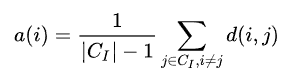

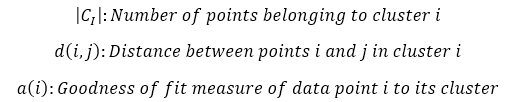

- <b>Note that the smaller the value of a(i), the better the assignment of point to its cluster</b>

2. Compute average of distance between current point of interest and all other points within a given neighboring cluster.

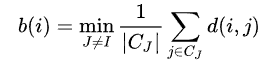

- <b>Note that the larger the value of b(i), the worse the assignment of point to its neighboring cluster</b>

3. Compute silhouette score for current point of interest using the following formula:

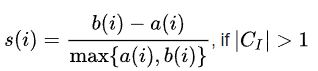

Silhouette coefficients/scores range between -1 to +1 with the following interpretation:
- 1: Sample is far away from neighboring clusters (very good clustering algorithm)
- Close to 0: Sample is close to decision boundary between two neighboring clusters (Average clustering algorithm)
- -1: Sample might have been assigned to the wrong cluster (Bad clustering algorithm)

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_silhouette_analysis_001.png">

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_silhouette_analysis_002.png">

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_silhouette_analysis_003.png">

From the example above, 4 clusters is considered optimum, because it has a good silhouette score of around 0.65 with little to no negative silhouette coefficients.

<b>Note that the silhouette plots above can be used to visualize values of silhouette coefficients for every sample and ideally silhouette score should be closer to 1 with little to no negative silhouette coefficients.</b>

<b>Advantages of silhouette score:</b>
1. Higher score when clusters are dense and well separated, which relates to a standard concept of a cluster.

<b>Disadvantages of silhouette score:</b>
1. Silhouette score is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

## Calinski-Harabasz Index

Calinski-Harabasz index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). Note that higher values indicate better clustering.

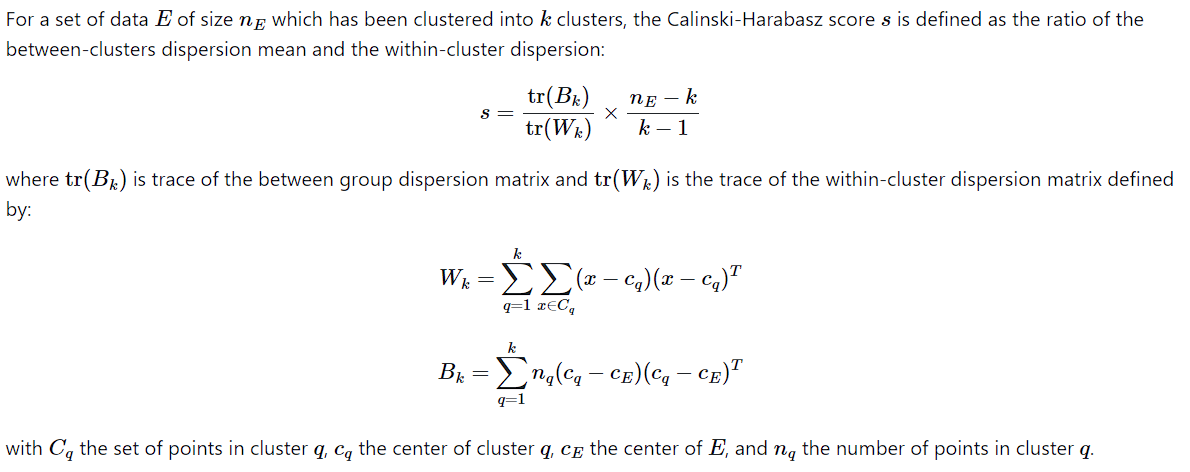

<b>Advantages of Calinski-Harabasz score:</b>
1. Higher score when clusters are dense and well separated, which relates to a standard concept of a cluster.
2. Score is fast to compute

<b>Disadvantages of Calinski-Harabasz score:</b>
1. Calinski-Harabasz score is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

## Davies-Bouldin Index

Davies-Bouldin index signifies the average similarity between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Note that values closer to zero indicate better clustering.

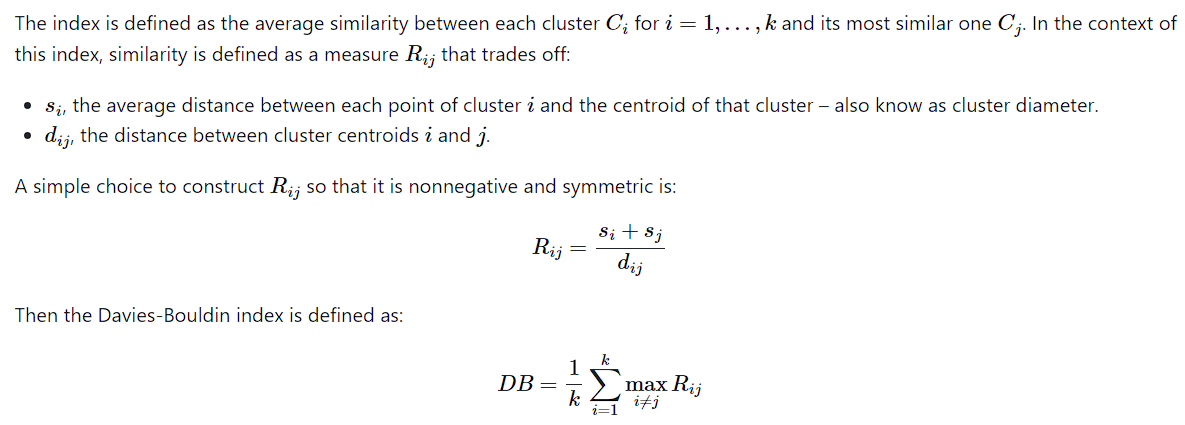

<b>Advantages of Davies-Bouldin score:</b>
1. Index is solely based on quantities and features inherent to the dataset as its computation only uses point-wise distances.
2. Simpler computation than silhouette score

<b>Disadvantages of Davies-Bouldin score:</b>
1. Davies-Bouldin score is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
2. Usage of centroid distance limits the distance metric to Euclidean space.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
import optuna
from sklearn.pipeline import Pipeline
from collections import Counter
import scipy.cluster.hierarchy as sch
from kneed import KneeLocator
from transformers import OutlierCapTransformer, ScalingTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [3]:
Counter(y)

Counter({0: 59, 1: 71, 2: 48})

In [4]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

More details related to Exploratory Data Analysis for classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Classification.ipynb

## K Means Clustering

In K means clustering, the value of K represents the number of centroid points that form given clusters, which requires hyperparameter tuning.

<img src="https://editor.analyticsvidhya.com/uploads/46668k-means-clustering-algorithm-in-machine-learning.png">

K Means clustering focuses on minimizing inertia/within-cluster sum-of-squares criterion:

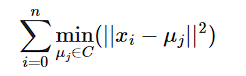

However, inertia criterion has the following drawbacks:
1. Assumes clusters are convex and isotropic, which is not always possible.
2. Not a normalized metric, such that euclidean distances tend to inflate for high dimensional spaces. Using dimensionality reduction techniques like PCA prior to K-means alleviate this problem and speeds up computation.

Note that convex clusters refer to ability to draw a straight line between two points in the cluster without leaving the cluster itself.
Image below shows an example of a non-convex cluster:

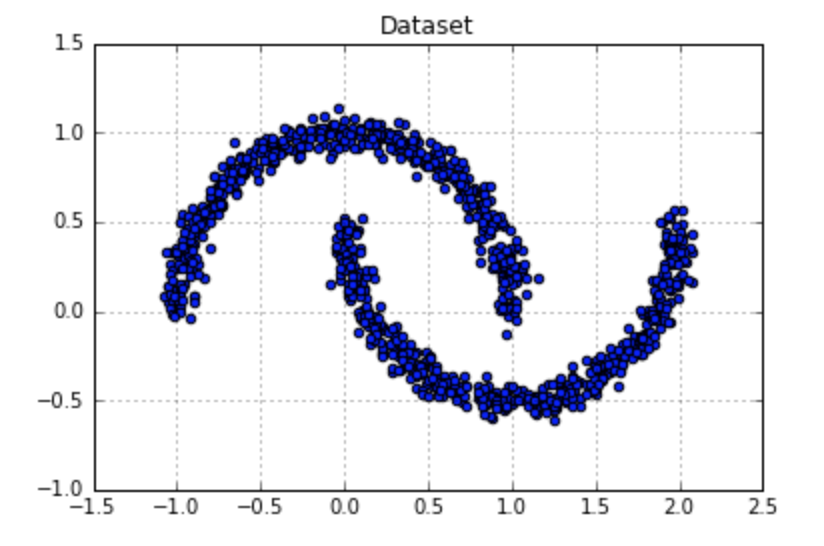

<b>Assumptions of K Means Clustering</b>:
1. Clusters are spherical
2. Clusters are of similar size

<b>Advantages of K Means Clustering:</b>
1. Computationally faster for smaller values of K
2. Clusters formed are more tight and precise
3. Scalable to large datasets

<b>Disadvantages of K Means Clustering:</b>
1. K value requires manual selection and hyperparameter tuning
2. Unable to cluster data with various size and density
3. Sensitive to outliers

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Steps of K means clustering</b>:

1. Initialize K number of centroids at random (Note that centroids need to be far enough initially for clusters to be identified accordingly - resolved using K means ++ in sklearn)

2. Compute Euclidean distance for every point of interest to determine closest centroid point to assign to

3. Compute average of all points similar to centroid point to update the location of centroid point

4. Steps 2 and 3 are repeated until no more points are reassigned to new centroid points based on convergence criterion where:
- Centroid points move less than certain percentage of smallest distance between different centroids
- Maximum iterations is reached

<b> Important hyperparameters for KMeans</b>:
1. n_clusters: Number of clusters

Note that hyperparameters for KMeans can be evaluated using either elbow + knee locator method or using hyperparameter tuning methods like Optuna.

In [5]:
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))

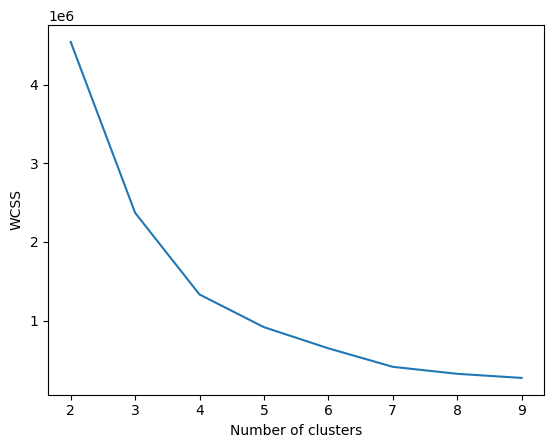

Optimum number of clusters: 4


In [6]:
X_transformed = pipeline.fit_transform(X)
# Using elbow method to identify optimum value of K
kmeans = KMeans().fit(X_transformed)
wcss = [] 
for i in range(2, 10): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 120)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()
kneeloc = KneeLocator(range(2,10), wcss, curve='convex', direction='decreasing')
print("Optimum number of clusters:",kneeloc.knee)

In [7]:
# Using Optuna to determine optimum number of clusters
def silhouette_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    clst = KMeans(random_state=120, n_clusters=n_clusters)
    clst.fit(X_transformed)
    labels = clst.predict(X_transformed)
    return silhouette_score(X_transformed, labels)

def calinski_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    clst = KMeans(random_state=120, n_clusters=n_clusters)
    clst.fit(X_transformed)
    labels = clst.predict(X_transformed)
    return calinski_harabasz_score(X_transformed, labels)

def bouldin_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    clst = KMeans(random_state=120, n_clusters=n_clusters)
    clst.fit(X_transformed)
    labels = clst.predict(X_transformed)
    return davies_bouldin_score(X_transformed, labels)

In [8]:
func = lambda trial: silhouette_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = KMeans(random_state=120, n_clusters=trial.params['n_clusters'])
clst.fit(X_transformed)
labels = clst.predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:11,826] A new study created in memory with name: no-name-df21d3e5-510e-4819-aa5e-6fe1a4da88d1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:11,947] Trial 0 finished with value: 0.12150106204452904 and parameters: {'n_clusters': 14}. Best is trial 0 with value: 0.12150106204452904.
[I 2022-11-10 07:19:12,183] Trial 1 finished with value: 0.13663140809435592 and parameters: {'n_clusters': 11}. Best is trial 1 with value: 0.13663140809435592.
[I 2022-11-10 07:19:12,429] Trial 2 finished with value: 0.13797401326342412 and parameters: {'n_clusters': 13}. Best is trial 2 with value: 0.13797401326342412.
[I 2022-11-10 07:19:12,686] Trial 3 finished with value: 0.13663140809435592 and parameters: {'n_clusters': 11}. Best is trial 2 with value: 0.13797401326342412.
[I 2022-11-10 07:19:12,939] Trial 4 finished with value: 0.14060216492905606 and parameters: {'n_clusters': 10}. Best is trial 4 with value: 0.14060216492905606.
[I 2022-11-10 07:19:13,275] Trial 5 finished with value: 0.13104042519967504 and parameters: {'n_clusters': 20}. Best is trial 4 with value: 0.14060216492905606.
[I 2022-11-10 07:19:13,584] 

Counter({1: 62, 2: 65, 0: 51})

In [9]:
func = lambda trial: calinski_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = KMeans(random_state=120, n_clusters=trial.params['n_clusters'])
clst.fit(X_transformed)
labels = clst.predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:17,288] A new study created in memory with name: no-name-1b8562da-d8cd-47c6-9b92-506b857df723


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:17,424] Trial 0 finished with value: 26.17158480843577 and parameters: {'n_clusters': 14}. Best is trial 0 with value: 26.17158480843577.
[I 2022-11-10 07:19:17,660] Trial 1 finished with value: 29.373103809895014 and parameters: {'n_clusters': 11}. Best is trial 1 with value: 29.373103809895014.
[I 2022-11-10 07:19:17,904] Trial 2 finished with value: 27.253514062240903 and parameters: {'n_clusters': 13}. Best is trial 1 with value: 29.373103809895014.
[I 2022-11-10 07:19:18,123] Trial 3 finished with value: 29.373103809895014 and parameters: {'n_clusters': 11}. Best is trial 1 with value: 29.373103809895014.
[I 2022-11-10 07:19:18,365] Trial 4 finished with value: 31.50785269165868 and parameters: {'n_clusters': 10}. Best is trial 4 with value: 31.50785269165868.
[I 2022-11-10 07:19:18,602] Trial 5 finished with value: 21.99908408008933 and parameters: {'n_clusters': 20}. Best is trial 4 with value: 31.50785269165868.
[I 2022-11-10 07:19:18,889] Trial 6 finished w

Counter({1: 62, 2: 65, 0: 51})

In [10]:
func = lambda trial: bouldin_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = KMeans(random_state=120, n_clusters=trial.params['n_clusters'])
clst.fit(X_transformed)
labels = clst.predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:21,801] A new study created in memory with name: no-name-4100853c-3389-4143-8a65-f8700059680b


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:21,984] Trial 0 finished with value: 1.6972972573903957 and parameters: {'n_clusters': 14}. Best is trial 0 with value: 1.6972972573903957.
[I 2022-11-10 07:19:22,180] Trial 1 finished with value: 1.703938707334152 and parameters: {'n_clusters': 11}. Best is trial 0 with value: 1.6972972573903957.
[I 2022-11-10 07:19:22,458] Trial 2 finished with value: 1.6570913592593328 and parameters: {'n_clusters': 13}. Best is trial 2 with value: 1.6570913592593328.
[I 2022-11-10 07:19:22,644] Trial 3 finished with value: 1.703938707334152 and parameters: {'n_clusters': 11}. Best is trial 2 with value: 1.6570913592593328.
[I 2022-11-10 07:19:22,837] Trial 4 finished with value: 1.7165073729166938 and parameters: {'n_clusters': 10}. Best is trial 2 with value: 1.6570913592593328.
[I 2022-11-10 07:19:23,075] Trial 5 finished with value: 1.5071277082891779 and parameters: {'n_clusters': 20}. Best is trial 5 with value: 1.5071277082891779.
[I 2022-11-10 07:19:23,298] Trial 6 finish

Counter({0: 113, 1: 65})

From the results above, using elbow's method shows that the optimum number of clusters is 4. Using silhouette score and calinski_harabasz_score shows that optimum number of clusters is 3, while using davies_bouldin_score shows that optimum number of clusters is 2.

## Hierarchical Clustering

In hierarchical clustering, number of clusters do not need to be defined upfront under agglomerative approach.

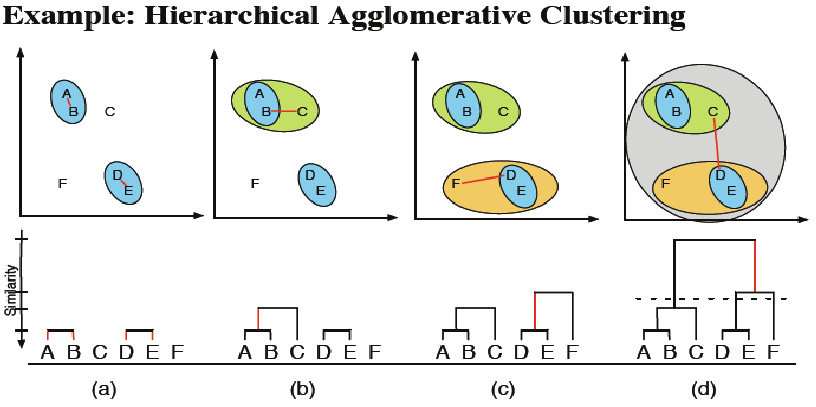

Hierarchical clustering is mostly suitable for small datasets

The following steps are involved in hierarchical clustering:

1. From N number of data points where each data point is treated as a single cluster, combine 2 points with the nearest distance into one cluster.

2. Repeat the 1st step until a single cluster remains.

Note that the formation of clusters in hierarchical clustering can be visualized using a dendrogram, which does not require assumptions about the shape of clusters

<b>The optimum value of clusters is determined based on the dendrogram, which is the number of points passes through the longest vertical line that has no other horizontal lines passing through</b>

<b>Assumptions of hierarchical clustering: No assumptions required</b>

<b>Advantages of hierarchical clustering</b>:
1. No assumption about shape of clusters required
2. Cluster datasets at various levels of granularity upfront

<b>Disadvantages of hierarchical clustering</b>:
1. Manual checks required to determine optimum number of clusters to select
2. Computationally expensive for large datasets
3. Dendrogram becomes difficult to visualize on large datasets.
4. Unable to cluster data with various size and density
5. Sensitive to outliers

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Steps of Hierarchical Clustering</b>:
1. Starting with n observations, treat each observation as its own cluster and compute pairwise distances between all observations.
2. Compare all pairwise distance based on given measure and assign two closest points or clusters within the same cluster. Height in dendrogram represents the euclidean distance between two points/clusters.
3. Compute new pairwise inter-cluster distances among remaining clusters.
4. Repeat steps 2 and 3 until only one cluster remains.
    
<b> Important hyperparameters for Hierarchical Clustering</b>:
1. n_clusters: Number of clusters
2. linkage: Type of distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

Note that hyperparameters for Hierarchical Clustering can be evaluated using either dendrogram method or using hyperparameter tuning methods like Optuna.

## Types of Linkage in Hierarchical Clustering

1 Single linkage: Smallest pairwise distance

- Highly sensitive to outliers when forming flat clusters

- Works well for low noise data with unusual structure

2 Complete linkage: Largest pairwise distance

- Less sensitive to outliers than single linkage

3 Average linkage: Average pairwise distance

4 Ward linkage: Pairwise distance that minimizes total variance within cluster

In [11]:
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))

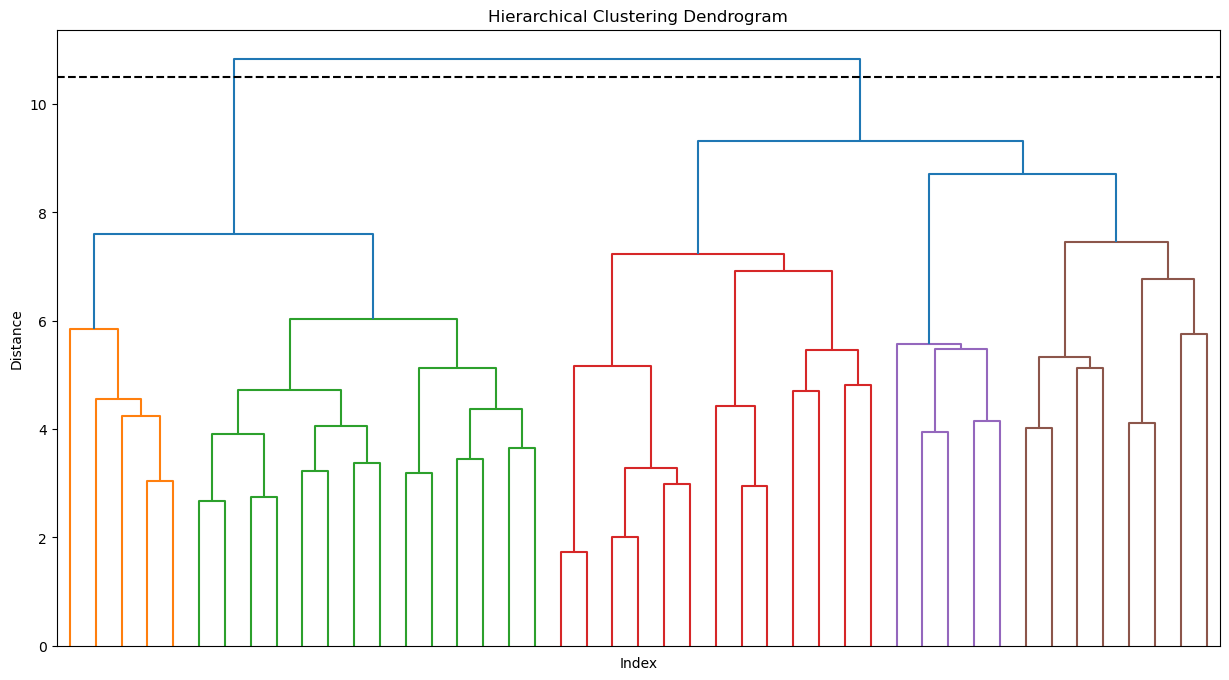

In [12]:
X_transformed = pipeline.fit_transform(X)
z = sch.linkage(X_transformed, method = "complete", metric = "euclidean")
# Dendrogram plot with viewing only first 5 levels since the dataset is very large
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
sch.dendrogram(z, orientation='top', no_labels=True, p=5, truncate_mode='level')
threshold = 10.5 #for hline
plt.axhline(y=threshold, c='k', linestyle='--')
plt.show()

In [13]:
def silhouette_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    linkage = trial.suggest_categorical('linkage',['ward', 'complete', 'average', 'single'])
    clst = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage)
    labels = clst.fit_predict(X_transformed)
    return silhouette_score(X_transformed, labels)

def calinski_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    linkage = trial.suggest_categorical('linkage',['ward', 'complete', 'average', 'single'])
    clst = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage)
    labels = clst.fit_predict(X_transformed)
    return calinski_harabasz_score(X_transformed, labels)

def bouldin_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    n_clusters = trial.suggest_int('n_clusters',2,20)
    linkage = trial.suggest_categorical('linkage',['ward', 'complete', 'average', 'single'])
    clst = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage)
    labels = clst.fit_predict(X_transformed)
    return davies_bouldin_score(X_transformed, labels)

In [14]:
func = lambda trial: silhouette_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AgglomerativeClustering(n_clusters=trial.params['n_clusters'], linkage=trial.params['linkage'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:26,422] A new study created in memory with name: no-name-2dd848ee-2246-455a-9fce-c3934510cdff


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:26,502] Trial 0 finished with value: 0.15629123209155044 and parameters: {'n_clusters': 14, 'linkage': 'complete'}. Best is trial 0 with value: 0.15629123209155044.
[I 2022-11-10 07:19:26,632] Trial 1 finished with value: 0.1324520309047607 and parameters: {'n_clusters': 20, 'linkage': 'ward'}. Best is trial 0 with value: 0.15629123209155044.
[I 2022-11-10 07:19:26,769] Trial 2 finished with value: 0.19095269088449066 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 2 with value: 0.19095269088449066.
[I 2022-11-10 07:19:26,905] Trial 3 finished with value: 0.1167585214449926 and parameters: {'n_clusters': 20, 'linkage': 'complete'}. Best is trial 2 with value: 0.19095269088449066.
[I 2022-11-10 07:19:27,041] Trial 4 finished with value: 0.21728701642481466 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 4 with value: 0.21728701642481466.
[I 2022-11-10 07:19:27,169] Trial 5 finished with value: 0.21716797446951583 and para

Counter({2: 64, 1: 58, 0: 56})

In [15]:
func = lambda trial: calinski_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AgglomerativeClustering(n_clusters=trial.params['n_clusters'], linkage=trial.params['linkage'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:29,139] A new study created in memory with name: no-name-ba39c3cb-f17d-4622-923c-432e9d2ab8db


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:29,216] Trial 0 finished with value: 22.518158535595536 and parameters: {'n_clusters': 14, 'linkage': 'complete'}. Best is trial 0 with value: 22.518158535595536.
[I 2022-11-10 07:19:29,346] Trial 1 finished with value: 21.596265907929716 and parameters: {'n_clusters': 20, 'linkage': 'ward'}. Best is trial 0 with value: 22.518158535595536.
[I 2022-11-10 07:19:29,473] Trial 2 finished with value: 18.602540323553885 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 0 with value: 22.518158535595536.
[I 2022-11-10 07:19:29,599] Trial 3 finished with value: 19.860250981970488 and parameters: {'n_clusters': 20, 'linkage': 'complete'}. Best is trial 0 with value: 22.518158535595536.
[I 2022-11-10 07:19:29,725] Trial 4 finished with value: 25.62618531583209 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 4 with value: 25.62618531583209.
[I 2022-11-10 07:19:29,852] Trial 5 finished with value: 38.117222717925536 and parameters: {'n

Counter({2: 64, 1: 58, 0: 56})

In [16]:
func = lambda trial: bouldin_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AgglomerativeClustering(n_clusters=trial.params['n_clusters'], linkage=trial.params['linkage'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:31,954] A new study created in memory with name: no-name-1427ebbf-4a0f-49ed-9853-18544707b815


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:32,034] Trial 0 finished with value: 1.3975484511385408 and parameters: {'n_clusters': 14, 'linkage': 'complete'}. Best is trial 0 with value: 1.3975484511385408.
[I 2022-11-10 07:19:32,163] Trial 1 finished with value: 1.493005924425932 and parameters: {'n_clusters': 20, 'linkage': 'ward'}. Best is trial 0 with value: 1.3975484511385408.
[I 2022-11-10 07:19:32,291] Trial 2 finished with value: 1.1853589188224858 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 2 with value: 1.1853589188224858.
[I 2022-11-10 07:19:32,421] Trial 3 finished with value: 1.4124120123246957 and parameters: {'n_clusters': 20, 'linkage': 'complete'}. Best is trial 2 with value: 1.1853589188224858.
[I 2022-11-10 07:19:32,549] Trial 4 finished with value: 1.1209553356803619 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 4 with value: 1.1209553356803619.
[I 2022-11-10 07:19:32,675] Trial 5 finished with value: 1.7841027280115114 and parameters: {'

Counter({0: 177, 1: 1})

From the results above, using dendrogram method shows that the optimum number of clusters is 2. Using silhouette score and calinski_harabasz_score shows that optimum number of clusters is 3, while using davies_bouldin_score shows that optimum number of clusters is 2.

## DBSCAN Clustering

<img src = "https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png" width="500">

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering is to form clusters of arbitrary shapes, which k-means and hierarchical clustering couldn't do.

<b>Terminologies of DBSCAN clustering</b>:

1. <b>Epsilon</b>: Radius of a cluster
2. <b>Min points</b>: Minimum number of points required within radius of cluster for centroid to be classified as "core point"
3. <b>Core points</b>: Centroid where there's at least n number of min points available within the cluster
4. <b>Border points</b>: Centroid where there's between 1 and n - 1 number of min points available within the cluster
5. <b>Noise points</b>: Centroid where there's no points available within the cluster.

Unlike K-means and hierarchical clustering, DBSCAN clustering is able to detect noise in the dataset.

<b>Assumptions of DBSCAN clustering:</b>
1. Clusters are dense regions in space separated by regions of lower density.

<b>Advantages of DBSCAN Clustering:</b>
1. Does not require specifying number of clusters upfront
2. Able to identify noise data when clustering
3. Able to find arbitrary size and shaped clusters

<b>Disadvantages of DBSCAN Clustering:</b>
1. Does not work well on high-dimensional data
2. Unable to cluster datasets with large difference in density

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: Yes</b>

<b>Steps of DBSCAN</b>:
1. Initialize random point and its neighboring points are identified based on eps value.
2. If point contains greater than or equal points than min_samples, the cluster is formed and the point becomes a core poiint, else it's considered as noise.
3. If the point is a core point, all its neighbors become a part of the cluster. If points in neighborhood are core points, then their neighbors are also part of the cluster
4. Repeat steps 1 to 3 until all points are classified into different clusters or noises.

<b>Important hyperparameters of DBSCAN</b>:
1. eps: Radius of a cluster
2. min_samples: Minimum number of points required within radius of cluster for centroid to be classified as "core point"

Note that points identified as noise in DBSCAN is assigned cluster value of -1.

In [17]:
def silhouette_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    eps = trial.suggest_float('eps',1,4,log=True)
    min_samples = trial.suggest_int('min_samples',2,20)
    clst = DBSCAN(eps=eps,min_samples=min_samples)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return silhouette_score(X_transformed, labels)

def calinski_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    eps = trial.suggest_float('eps',1,4,log=True)
    min_samples = trial.suggest_int('min_samples',2,20)
    clst = DBSCAN(eps=eps,min_samples=min_samples)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return calinski_harabasz_score(X_transformed, labels)

def bouldin_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    eps = trial.suggest_float('eps',1,4,log=True)
    min_samples = trial.suggest_int('min_samples',2,20)
    clst = DBSCAN(eps=eps,min_samples=min_samples)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return davies_bouldin_score(X_transformed, labels)

In [18]:
pipeline = Pipeline(steps=[])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))

In [19]:
func = lambda trial: silhouette_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = DBSCAN(eps=trial.params['eps'], min_samples=trial.params['min_samples'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:34,680] A new study created in memory with name: no-name-a27384e8-8be3-4706-94e3-ec72c77a30d4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:34,716] Trial 0 finished with value: 0.21199057733148635 and parameters: {'eps': 2.5595870927077393, 'min_samples': 11}. Best is trial 0 with value: 0.21199057733148635.
[I 2022-11-10 07:19:34,802] Trial 1 finished with value: 0.12919767964441778 and parameters: {'eps': 2.3741505518552675, 'min_samples': 11}. Best is trial 0 with value: 0.21199057733148635.
[I 2022-11-10 07:19:34,884] Trial 2 pruned. 
[I 2022-11-10 07:19:34,974] Trial 3 finished with value: 0.2427439435192829 and parameters: {'eps': 3.9153769216738796, 'min_samples': 18}. Best is trial 3 with value: 0.2427439435192829.
[I 2022-11-10 07:19:35,063] Trial 4 finished with value: 0.16546907890080323 and parameters: {'eps': 2.2691951571317857, 'min_samples': 5}. Best is trial 3 with value: 0.2427439435192829.
[I 2022-11-10 07:19:35,151] Trial 5 finished with value: -0.29203307256066147 and parameters: {'eps': 1.4386546463411822, 'min_samples': 3}. Best is trial 3 with value: 0.2427439435192829.
[I 2022-11

Counter({0: 171, -1: 7})

In [20]:
func = lambda trial: calinski_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = DBSCAN(eps=trial.params['eps'], min_samples=trial.params['min_samples'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:36,627] A new study created in memory with name: no-name-a6893a49-8517-49e0-8bdf-95c7e25a3a03


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:36,663] Trial 0 finished with value: 34.32396365317588 and parameters: {'eps': 2.5595870927077393, 'min_samples': 11}. Best is trial 0 with value: 34.32396365317588.
[I 2022-11-10 07:19:36,785] Trial 1 finished with value: 27.0611995553555 and parameters: {'eps': 2.3741505518552675, 'min_samples': 11}. Best is trial 0 with value: 34.32396365317588.
[I 2022-11-10 07:19:36,905] Trial 2 pruned. 
[I 2022-11-10 07:19:37,031] Trial 3 finished with value: 5.813937744208825 and parameters: {'eps': 3.9153769216738796, 'min_samples': 18}. Best is trial 0 with value: 34.32396365317588.
[I 2022-11-10 07:19:37,142] Trial 4 finished with value: 28.633242557126962 and parameters: {'eps': 2.2691951571317857, 'min_samples': 5}. Best is trial 0 with value: 34.32396365317588.
[I 2022-11-10 07:19:37,227] Trial 5 finished with value: 2.4810812753292226 and parameters: {'eps': 1.4386546463411822, 'min_samples': 3}. Best is trial 0 with value: 34.32396365317588.
[I 2022-11-10 07:19:37,315

Counter({0: 103, -1: 28, 1: 47})

In [21]:
func = lambda trial: bouldin_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = DBSCAN(eps=trial.params['eps'], min_samples=trial.params['min_samples'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:38,624] A new study created in memory with name: no-name-cf31d7ef-2840-4819-9476-2bc6d82b243d


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:38,659] Trial 0 finished with value: 3.2658288104425828 and parameters: {'eps': 2.5595870927077393, 'min_samples': 11}. Best is trial 0 with value: 3.2658288104425828.
[I 2022-11-10 07:19:38,745] Trial 1 finished with value: 2.6456429397954198 and parameters: {'eps': 2.3741505518552675, 'min_samples': 11}. Best is trial 1 with value: 2.6456429397954198.
[I 2022-11-10 07:19:38,826] Trial 2 pruned. 
[I 2022-11-10 07:19:38,919] Trial 3 finished with value: 2.319474093003819 and parameters: {'eps': 3.9153769216738796, 'min_samples': 18}. Best is trial 3 with value: 2.319474093003819.
[I 2022-11-10 07:19:39,017] Trial 4 finished with value: 3.627038145908424 and parameters: {'eps': 2.2691951571317857, 'min_samples': 5}. Best is trial 3 with value: 2.319474093003819.
[I 2022-11-10 07:19:39,113] Trial 5 finished with value: 1.5995660433510877 and parameters: {'eps': 1.4386546463411822, 'min_samples': 3}. Best is trial 5 with value: 1.5995660433510877.
[I 2022-11-10 07:19:3

Counter({0: 19,
         -1: 104,
         1: 9,
         2: 2,
         3: 2,
         4: 2,
         5: 4,
         6: 2,
         7: 3,
         8: 5,
         9: 3,
         10: 3,
         11: 2,
         12: 4,
         13: 3,
         14: 2,
         15: 7,
         16: 2})

## Affinity Propagation

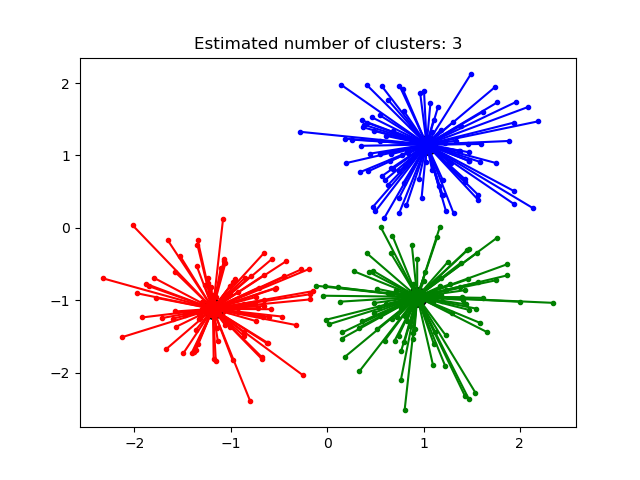

Affinity propagation method models each data point as a node in a network. During the clustering process, real-valued messages are recursively exchanged between data points until a high quality set of exemplars and corresponding clusters emerges.

<b>Advantages of Affinity Propagation Clustering:</b>
1. Does not require specifying number of clusters upfront
2. Able to find arbitrary size and shaped clusters
3. Most suitable for small to medium sized datasets

<b>Disadvantages of Affinity Propagation  Clustering:</b>
1. Does not work well on high-dimensional data due to large time complexity (O(N^2*T) 
- N: Number of samples
- T: Number of iterations to convergence

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Steps of Affinity Propagation</b>:
1. Compute similarity matrix for off-diagonal points (sum of squared differences)

2. Assign smallest value to all diagonal points in the similarity matrix

3. Compute responsibility matrix between off-diagonal points using the following formula:

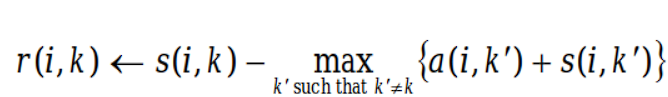

Formula above represents difference between similarity score between row i and column k and maximum of remaining similarity scores for row i. Note that diagonal points in responsibility matrix remains the same.

4. Compute availability matrix for diagonal points using the following formula:

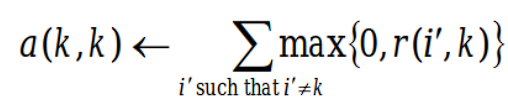

Formula above represents sum of all non-negative values (different points) along column k.

5. Compute availability matrix for off-diagonal points using the following formula:

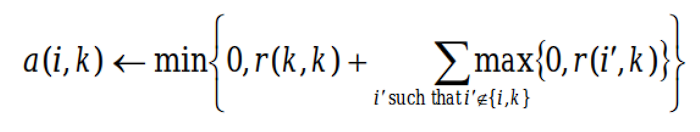

Formula above represents value of diagonal point k plus remaining positive values along column k excluding value for pair (i,k)

6. Compute criterion matrix as sum of responsibility matrix and availability matrix.

7. Assign examplar for every row based on highest criterion value. Rows that share the same exemplar are assigned the same cluster.

8. Repeat steps 1 to 7 above until convergence or maximum number of iterations reached.

More details about the steps above for Affinity Propagation can be referred from the following article:
https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8

<b>Important hyperparameters of Affinity Propagation</b>:
1. damping: Damping factor (lambda) in the range between 0.5 and 1 (exclusive) represents extent to which current value is maintained relative to incoming values to avoid numerical oscillations when updating messages.

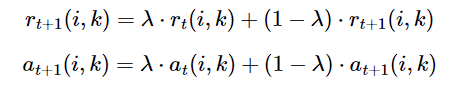

In [22]:
def silhouette_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    damping = trial.suggest_float('damping',0.5,1,log=True)
    clst = AffinityPropagation(random_state=120,damping=damping)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return silhouette_score(X_transformed, labels)

def calinski_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    damping = trial.suggest_float('damping',0.5,1,log=True)
    clst = AffinityPropagation(random_state=120,damping=damping)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return calinski_harabasz_score(X_transformed, labels)

def bouldin_obj(trial, X, pipeline):
    X_transformed = pipeline.fit_transform(X)
    damping = trial.suggest_float('damping',0.5,1,log=True)
    clst = AffinityPropagation(random_state=120,damping=damping)
    labels = clst.fit_predict(X_transformed)
    if len(np.unique(labels)) == 1:
        raise optuna.TrialPruned()
    else:
        return davies_bouldin_score(X_transformed, labels)

In [23]:
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))

In [24]:
func = lambda trial: silhouette_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AffinityPropagation(random_state=120, damping=trial.params['damping'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:40,521] A new study created in memory with name: no-name-1362e234-193f-492c-815b-20953f7a1e31


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:40,625] Trial 0 finished with value: 0.11854643369488176 and parameters: {'damping': 0.7999354806338664}. Best is trial 0 with value: 0.11854643369488176.
[I 2022-11-10 07:19:40,773] Trial 1 finished with value: 0.11854643369488176 and parameters: {'damping': 0.7134868781670795}. Best is trial 0 with value: 0.11854643369488176.
[I 2022-11-10 07:19:40,923] Trial 2 finished with value: 0.11854643369488176 and parameters: {'damping': 0.7704139393623515}. Best is trial 0 with value: 0.11854643369488176.
[I 2022-11-10 07:19:41,072] Trial 3 finished with value: 0.11854643369488176 and parameters: {'damping': 0.6959919211973687}. Best is trial 0 with value: 0.11854643369488176.
[I 2022-11-10 07:19:41,216] Trial 4 finished with value: 0.11854643369488176 and parameters: {'damping': 0.6878947804652404}. Best is trial 0 with value: 0.11854643369488176.
[I 2022-11-10 07:19:41,416] Trial 5 finished with value: 0.11577755947025478 and parameters: {'damping': 0.9665155615345487}.

Counter({4: 16,
         0: 17,
         2: 17,
         1: 4,
         3: 11,
         5: 7,
         8: 15,
         7: 17,
         6: 3,
         14: 16,
         10: 17,
         13: 8,
         12: 6,
         9: 3,
         11: 21})

In [25]:
func = lambda trial: calinski_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AffinityPropagation(random_state=120, damping=trial.params['damping'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:44,137] A new study created in memory with name: no-name-3b67cd8d-c3f7-4a34-b69b-4fa1013e0ff4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:44,250] Trial 0 finished with value: 23.93895306961693 and parameters: {'damping': 0.7999354806338664}. Best is trial 0 with value: 23.93895306961693.
[I 2022-11-10 07:19:44,400] Trial 1 finished with value: 23.93895306961693 and parameters: {'damping': 0.7134868781670795}. Best is trial 0 with value: 23.93895306961693.
[I 2022-11-10 07:19:44,561] Trial 2 finished with value: 23.93895306961693 and parameters: {'damping': 0.7704139393623515}. Best is trial 0 with value: 23.93895306961693.
[I 2022-11-10 07:19:44,707] Trial 3 finished with value: 23.93895306961693 and parameters: {'damping': 0.6959919211973687}. Best is trial 0 with value: 23.93895306961693.
[I 2022-11-10 07:19:44,850] Trial 4 finished with value: 23.93895306961693 and parameters: {'damping': 0.6878947804652404}. Best is trial 0 with value: 23.93895306961693.
[I 2022-11-10 07:19:45,051] Trial 5 finished with value: 25.19819078194764 and parameters: {'damping': 0.9665155615345487}. Best is trial 5 with 

Counter({1: 46, 3: 27, 0: 5, 4: 12, 7: 14, 8: 18, 2: 3, 5: 26, 6: 27})

In [26]:
func = lambda trial: bouldin_obj(trial, X, pipeline)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial
X_transformed = pipeline.fit_transform(X)
clst = AffinityPropagation(random_state=120, damping=trial.params['damping'])
labels = clst.fit_predict(X_transformed)
Counter(labels)

[I 2022-11-10 07:19:47,787] A new study created in memory with name: no-name-0363a42b-731c-40a8-b6c8-b863658b70ca


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-10 07:19:47,892] Trial 0 finished with value: 1.7401557527359834 and parameters: {'damping': 0.7999354806338664}. Best is trial 0 with value: 1.7401557527359834.
[I 2022-11-10 07:19:48,041] Trial 1 finished with value: 1.7401557527359834 and parameters: {'damping': 0.7134868781670795}. Best is trial 0 with value: 1.7401557527359834.
[I 2022-11-10 07:19:48,195] Trial 2 finished with value: 1.7401557527359834 and parameters: {'damping': 0.7704139393623515}. Best is trial 0 with value: 1.7401557527359834.
[I 2022-11-10 07:19:48,345] Trial 3 finished with value: 1.7401557527359834 and parameters: {'damping': 0.6959919211973687}. Best is trial 0 with value: 1.7401557527359834.
[I 2022-11-10 07:19:48,495] Trial 4 finished with value: 1.7401557527359834 and parameters: {'damping': 0.6878947804652404}. Best is trial 0 with value: 1.7401557527359834.
[I 2022-11-10 07:19:48,696] Trial 5 finished with value: 1.8404452362277117 and parameters: {'damping': 0.9665155615345487}. Best is tr

Counter({4: 16,
         0: 17,
         2: 17,
         1: 4,
         3: 11,
         5: 7,
         8: 15,
         7: 17,
         6: 3,
         14: 16,
         10: 17,
         13: 8,
         12: 6,
         9: 3,
         11: 21})